In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Data Understanding

### Collect Initial Data

In [2]:
DATASET_PATH = '../data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
commands = commands[commands != 'README.md']

### Describe Data

In [5]:
filenames = []
for command in commands:
      filenames += tf.io.gfile.glob(str(data_dir/command) + '/*')

filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
for command in commands:
      num_samples_per_command = len(tf.io.gfile.glob(str(data_dir/command) + '/*'))
      print(f'Number of examples for {command}: {num_samples_per_command}')

Number of total examples: 8000
Number of examples for down: 1000
Number of examples for go: 1000
Number of examples for left: 1000
Number of examples for no: 1000
Number of examples for right: 1000
Number of examples for stop: 1000
Number of examples for up: 1000
Number of examples for yes: 1000


### Explore Data

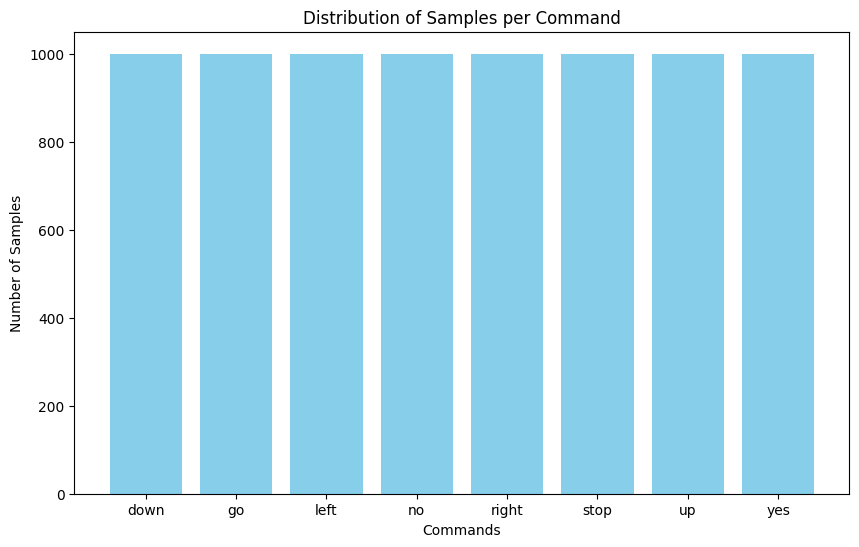

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(commands, num_samples_per_command, color='skyblue')
plt.xlabel('Commands')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Command')
plt.show()

### Verify Data Quality

In [7]:
commands = commands[(commands != 'go')
                & (commands != 'stop') & (commands != 'yes')]

print('Commands:', commands)

Commands: ['down' 'left' 'no' 'right' 'up']


In [8]:
filenames = []
for command in commands:
      filenames += tf.io.gfile.glob(str(data_dir/command) + '/*')

filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/command))))
print('Example file tensor:', filenames[0])

Number of total examples: 5000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'..\\data\\mini_speech_commands\\up\\e5dadd24_nohash_2.wav', shape=(), dtype=string)


# Data Preparation

### Select Data

In [9]:
train_files = filenames[:4000]
val_files = filenames[4000:4500]
test_files = filenames[4500:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4000
Validation set size 500
Test set size 500


In [10]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')

test_audio, _ = tf.audio.decode_wav(contents=test_file)

test_audio.shape

TensorShape([13654, 1])

### Clean Data

In [11]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    """
    Menghilangkan dimensi yang tidak perlu dari tensor audio sehingga
    tensor hasilnya adalah satu dimensi (menghilangkan dimensi kanal).
    """
    return tf.squeeze(audio, axis=-1)

In [12]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    return parts[-2]

In [13]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

### Construct Data

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

"""
Menerapkan fungsi get_waveform_and_label pada setiap elemen
dalam dataset files_ds secara paralel, menggunakan AUTOTUNE untuk optimasi kinerja.
"""
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

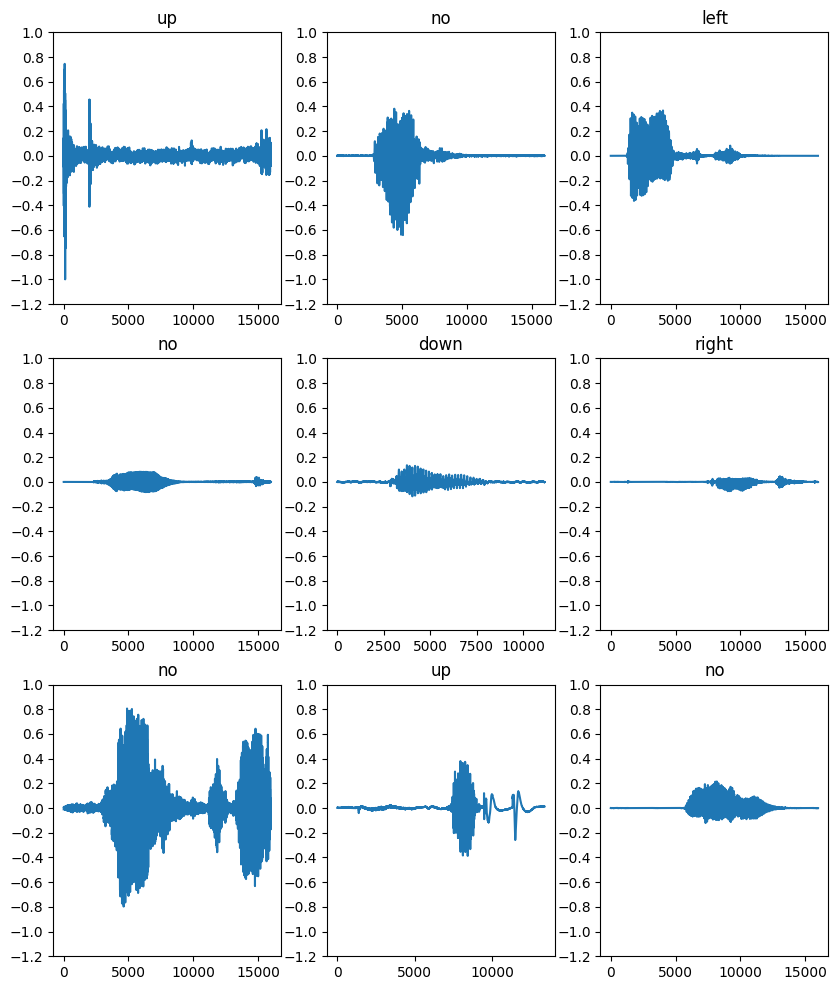

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

### Integrate Data

In [16]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)

    waveform = tf.cast(waveform, dtype=tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [17]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label: ', label)
print('Waveform shape: ', waveform.shape)
print('Spectrogram shape: ', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))


Label:  up
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


### Format Data

In [18]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

<function matplotlib.pyplot.show(close=None, block=None)>

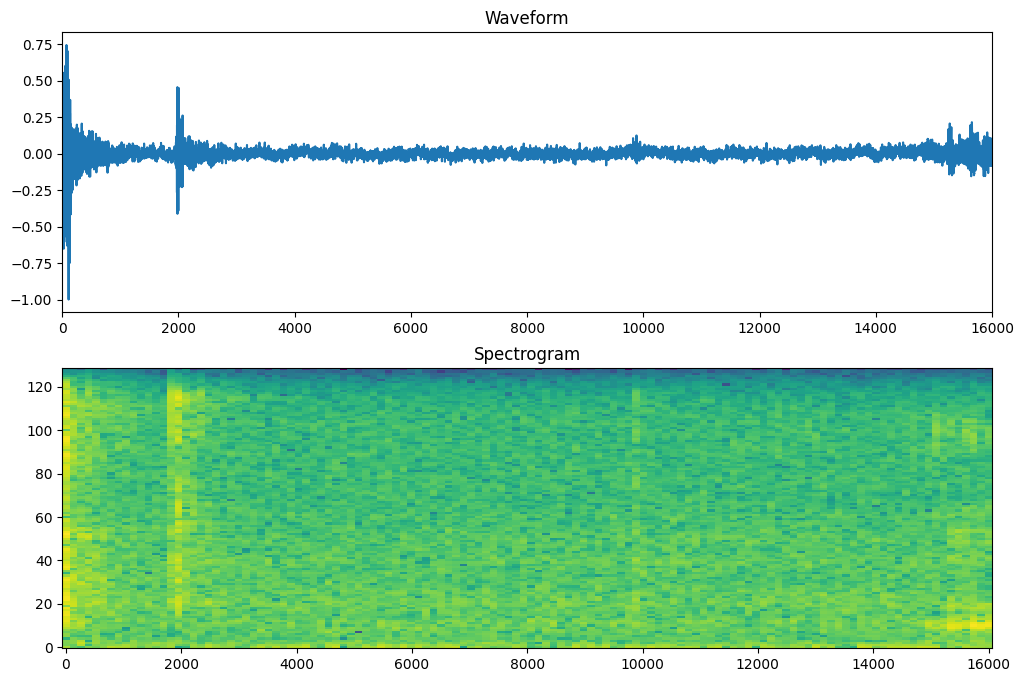

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show

# Modeling

### Select Modeling Techniques

In [20]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id

In [21]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE)

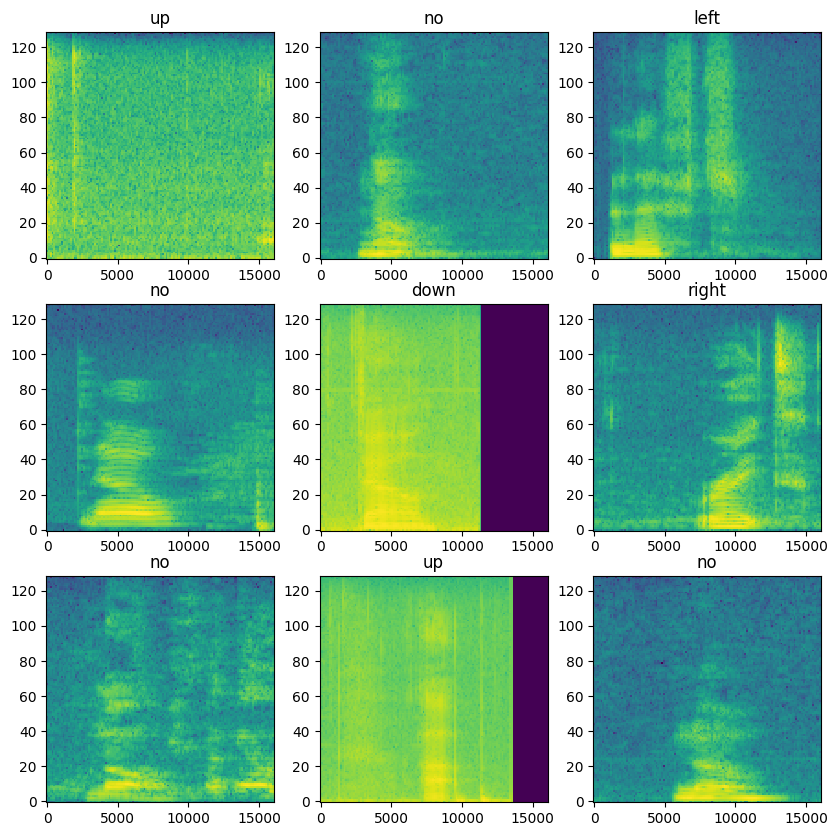

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])

plt.show()

### Generate Test Design

In [23]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [24]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [25]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [26]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape: ', input_shape)
num_labels = len(commands)

### Build Model

In [27]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),

])

model.summary()

Input shape:  (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)        

### Assess Model

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    metrics=['accuracy']
)

In [29]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


63/63 [==============================] - 5s 58ms/step - loss: 1.4358 - accuracy: 0.4185 - val_loss: 1.0762 - val_accuracy: 0.6580
Epoch 2/10
63/63 [==============================] - 2s 37ms/step - loss: 0.9407 - accuracy: 0.6665 - val_loss: 0.6754 - val_accuracy: 0.7900
Epoch 3/10
63/63 [==============================] - 2s 39ms/step - loss: 0.6505 - accuracy: 0.7710 - val_loss: 0.5107 - val_accuracy: 0.8560
Epoch 4/10
63/63 [==============================] - 2s 37ms/step - loss: 0.4986 - accuracy: 0.8328 - val_loss: 0.4228 - val_accuracy: 0.8620
Epoch 5/10
63/63 [==============================] - 2s 36ms/step - loss: 0.3993 - accuracy: 0.8630 - val_loss: 0.3787 - val_accuracy: 0.8820
Epoch 6/10
63/63 [==============================] - 2s 36ms/step - loss: 0.3360 - accuracy: 0.8855 - val_loss: 0.3899 - val_accuracy: 0.8960
Epoch 7/10
63/63 [==============================] - 2s 37ms/step - loss: 0.2746 - accuracy: 0.9072 - val_loss: 0.3635 - val_accuracy: 0.8900
Epoch 8/10


# Evaluation

### Evaluate Results

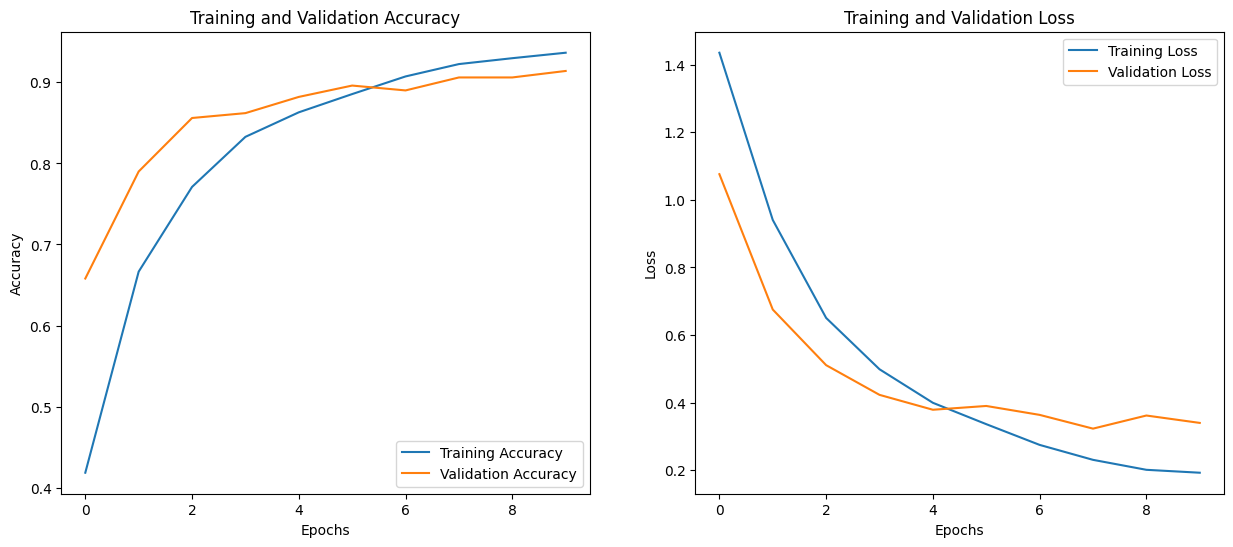

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [32]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

16/16 [==============================] - 0s 7ms/step
Test set accuracy: 89%


### Review Process

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        94
           1       0.89      0.86      0.87       101
           2       0.82      0.87      0.84       106
           3       0.92      0.90      0.91       100
           4       0.90      0.95      0.92        99

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



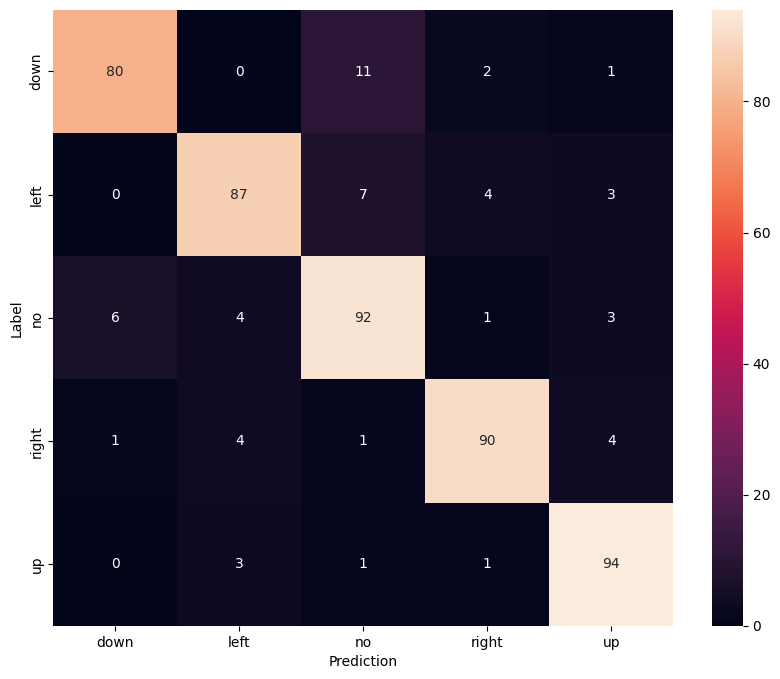

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [35]:
def predict_sample(sample_file, model, commands):
    sample_ds = preprocess_dataset([str(sample_file)])

    for spectrogram, label in sample_ds.batch(1):
        prediction = model(spectrogram)
        label_pred = np.argmax(prediction, axis=1)
        print("Predicted label:", commands[label_pred[0]])
        plt.bar(commands, tf.nn.softmax(prediction[0]))
        plt.title(f'Predictions for "{commands[label[0]]}"')
        plt.show()

# Deployment

Predicted label: down


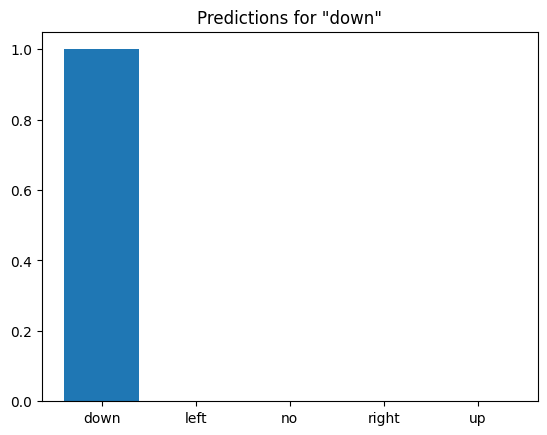

In [36]:
sample_file = data_dir/'down/feb1d305_nohash_1.wav'
predict_sample(sample_file, model, commands)

Predicted label: left


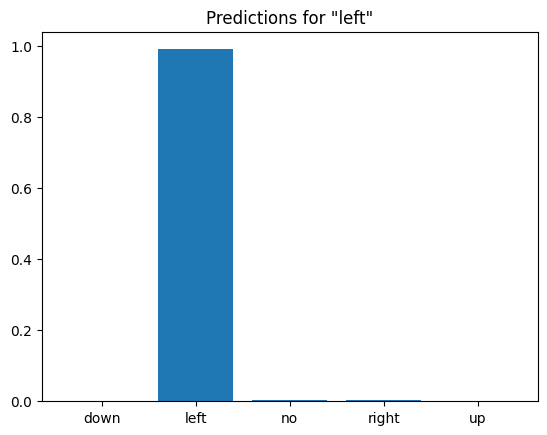

In [37]:
sample_file = data_dir/'left/1ecfb537_nohash_1.wav'
predict_sample(sample_file, model, commands)

Predicted label: right


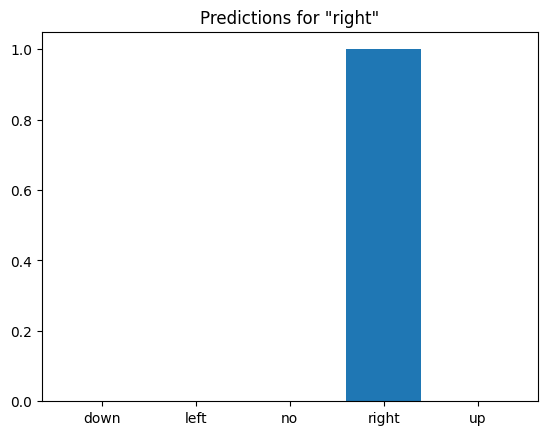

In [38]:
sample_file = data_dir/'right/2cf28b70_nohash_0.wav'
predict_sample(sample_file, model, commands)

Predicted label: up


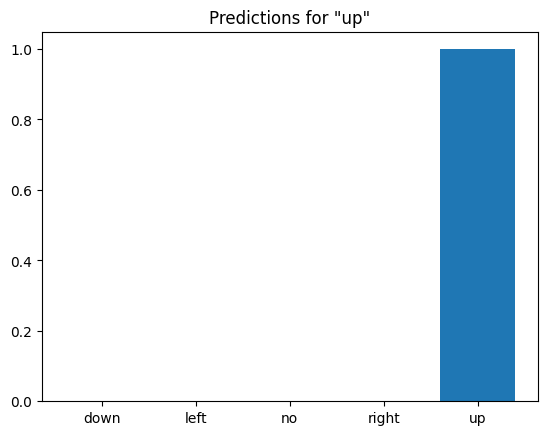

In [39]:
sample_file = data_dir/'up/f5733968_nohash_2.wav'
predict_sample(sample_file, model, commands)

In [40]:
model.save('../audioModel')

INFO:tensorflow:Assets written to: ../audioModel\assets


INFO:tensorflow:Assets written to: ../audioModel\assets
